### **Anurag Pratap Singh**
### **221020411**
## Lab 5

1. Importing libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)


2. Loading Dataset

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.4)
x = lfw_people.images
y = lfw_people.target
x = np.expand_dims(x, -1).astype("float32") / 255.0
x = tf.image.resize(x, (32, 32))
x, y = x[:1000], y[:1000]

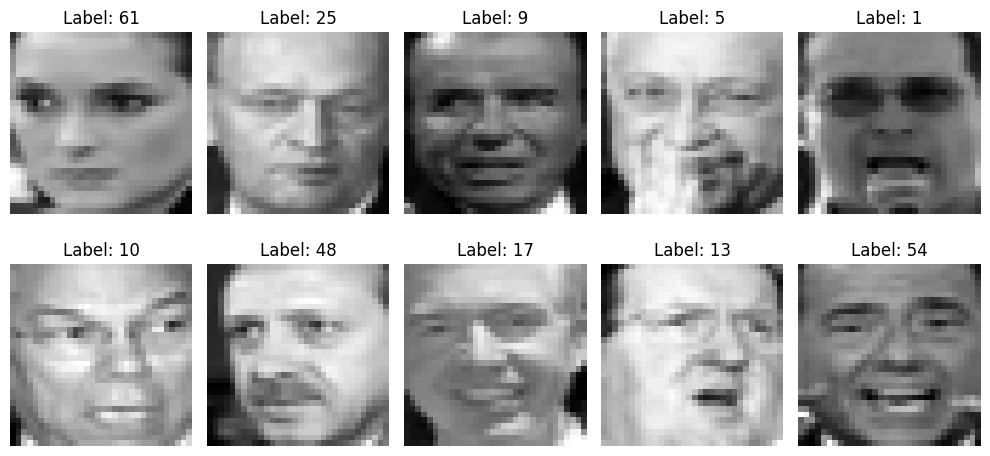

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(tf.squeeze(x[i]), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


3. Creating base network

In [ ]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    return Model(input, x)

input_shape = (32, 32, 1)
base_network = create_base_network(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

embedding_anchor = base_network(input_anchor)
embedding_positive = base_network(input_positive)
embedding_negative = base_network(input_negative)


4. defining triplet loss

In [ ]:
def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
        pos_dist = K.sum(K.square(anchor - positive), axis=-1)
        neg_dist = K.sum(K.square(anchor - negative), axis=-1)
        return K.maximum(pos_dist - neg_dist + margin, 0.0)
    return loss

siamese_network = Model(inputs=[input_anchor, input_positive, input_negative],
                        outputs=[embedding_anchor, embedding_positive, embedding_negative])

siamese_network.compile(optimizer=Adam(learning_rate=0.0001), loss=triplet_loss(margin=0.5))

In [ ]:
def create_triplets(x, y):
    triplets = []
    for i in range(len(x)):
        anchor = x[i]
        label = y[i]
        positive = x[y == label][np.random.randint(0, len(x[y == label]))]
        negative = x[y != label][np.random.randint(0, len(x[y != label]))]
        triplets.append([anchor, positive, negative])
    return np.array(triplets)

x_triplets = create_triplets(x, y)
print("done")

done


In [ ]:
history = siamese_network.fit([x_triplets[:, 0], x_triplets[:, 1], x_triplets[:, 2]],
                              np.zeros((x_triplets.shape[0], 2)),
                              batch_size=32,
                              epochs=30,
                              validation_split=0.2)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5000 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


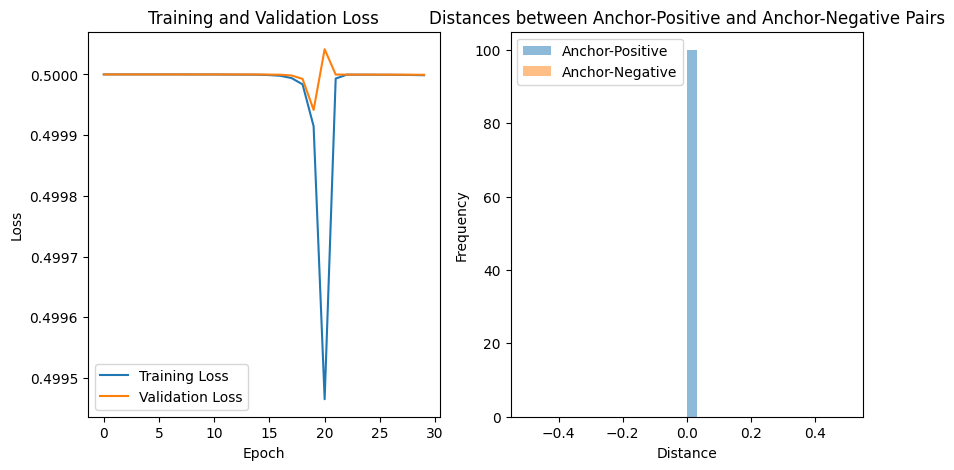

In [ ]:
embeddings_anchor, embeddings_positive, embeddings_negative = siamese_network.predict([x[:100], x[:100], x[100:200]])

pos_dist = np.sum(np.square(embeddings_anchor - embeddings_positive), axis=-1)
neg_dist = np.sum(np.square(embeddings_anchor - embeddings_negative), axis=-1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.hist(pos_dist, bins=30, alpha=0.5, label='Anchor-Positive')
plt.hist(neg_dist, bins=30, alpha=0.5, label='Anchor-Negative')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distances between Anchor-Positive and Anchor-Negative Pairs')

plt.show()
